# Tuning y Selección de Modelos Avanzados

En este notebook se exploran, ajustan y seleccionan modelos avanzados (Random Forest, XGBoost, etc.) para predecir el éxito de startups. Se emplean técnicas de validación cruzada y búsqueda de hiperparámetros.

Carga de datos y preprocesamiento

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import pickle
import sys
from pathlib import Path
from collections import Counter

# Añadir directorio raíz al path
sys.path.append(str(Path().resolve().parent))

from src.config import PROCESSED_DATA_DIR, MODELS_DIR, RANDOM_STATE, TEST_SIZE, TARGET_COLUMN

# --- Carga y limpieza de datos para comparación de modelos avanzados ---
df = pd.read_csv(PROCESSED_DATA_DIR / "startup_data_processed.csv")

prefijos_a_eliminar = [
    'closed', 'name', 'city', 'id', 'object', 'last', 'first', 'zip', 'Unnamed:', 'founded'
]
cols_problematicas = [col for col in df.columns if any(col.startswith(pref) for pref in prefijos_a_eliminar)]
df = df.drop(columns=cols_problematicas)

columnas_a_eliminar = [
    'Unnamed: 0', 'id', 'object_id', 'Unnamed: 6', 'state_code.1',
    'zip_code', 'city', 'name', 'closed_at',
    'founded_at', 'first_funding_at', 'last_funding_at', 'labels'
]
df = df.drop(columns=[col for col in columnas_a_eliminar if col in df.columns])

cols_baja_var = [col for col in df.columns if df[col].nunique() <= 1]
df = df.drop(columns=cols_baja_var)

X = df.drop(TARGET_COLUMN, axis=1)
y = df[TARGET_COLUMN]


Definición de modelos y grids de hiperparámetros

In [2]:
# --- Definición de modelos avanzados: Random Forest y XGBoost ---

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Definir el modelo Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Definir el modelo XGBoost
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

print("Modelos avanzados definidos: Random Forest y XGBoost")

Modelos avanzados definidos: Random Forest y XGBoost


Búsqueda de hiperparámetros (GridSearchCV/RandomizedSearchCV)

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import joblib

le = LabelEncoder()
y_encoded = le.fit_transform(y)

print([col for col in X.columns if 'status' in col or 'acquired' in col or 'closed' in col or 'id' in col])
print([col for col in X.columns if X[col].nunique() == len(X)])

cols_muchos_unicos = [col for col in X.columns if X[col].nunique() > 0.9 * len(X)]
print("Columnas con muchos valores únicos:", cols_muchos_unicos)

for col in X.columns:
    if X[col].nunique() > 1:
        corr = np.corrcoef(X[col], y_encoded)[0, 1]
        if abs(corr) > 0.99:
            print(f"Columna {col} tiene correlación perfecta con el target: {corr}")

print([col for col in X.columns if X[col].nunique() <= 1])





# --- Definir grids de hiperparámetros ---
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 3]
}

xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# --- Búsqueda de hiperparámetros con GridSearchCV ---

# Random Forest
print("Buscando mejores hiperparámetros para Random Forest...")
rf_grid = GridSearchCV(
    rf_model, rf_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2
)
rf_grid.fit(X, y_encoded)
print("Mejor configuración RF:", rf_grid.best_params_)
print("Mejor accuracy (CV):", rf_grid.best_score_)
joblib.dump(rf_grid.best_estimator_, MODELS_DIR / "best_rf_model.pkl")

# XGBoost
print("Buscando mejores hiperparámetros para XGBoost...")
xgb_grid = GridSearchCV(
    xgb_model, xgb_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2
)
xgb_grid.fit(X, y_encoded)
print("Mejor configuración XGB:", xgb_grid.best_params_)
print("Mejor accuracy (CV):", xgb_grid.best_score_)
joblib.dump(xgb_grid.best_estimator_, MODELS_DIR / "best_xgb_model.pkl")

['is_gamesvideo', 'category_code_games_video', 'category_code_photo_video']
[]
Columnas con muchos valores únicos: []
[]
Buscando mejores hiperparámetros para Random Forest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejor configuración RF: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Mejor accuracy (CV): 0.7995417156286722
Buscando mejores hiperparámetros para XGBoost...
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Users\alexl\OneDrive\Escritorio\Machine Learning\startups-ml\venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\alexl\OneDrive\Escritorio\Machine Learning\startups-ml\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\alexl\OneDrive\Escritorio\Machine Learning\startups-ml\venv\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\alexl\OneDrive\Escri

Mejor configuración XGB: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Mejor accuracy (CV): 0.7984841363102233


['C:\\Users\\alexl\\OneDrive\\Escritorio\\Machine Learning\\startups-ml\\models\\best_xgb_model.pkl']

Muestra las métricas medias y desviaciones estándar de la validación cruzada.

In [4]:
#Muestra las métricas medias y desviaciones estándar de la validación cruzada.

import pandas as pd

# Resultados de validación cruzada para Random Forest
rf_cv_results = pd.DataFrame(rf_grid.cv_results_)
print("Resultados de validación cruzada - Random Forest:")
print("Mejores hiperparámetros:", rf_grid.best_params_)
print(f"Mejor accuracy (media CV): {rf_grid.best_score_:.4f}")
print(f"Desviación estándar (CV): {rf_cv_results.loc[rf_grid.best_index_, 'std_test_score']:.4f}")

# Resultados de validación cruzada para XGBoost
xgb_cv_results = pd.DataFrame(xgb_grid.cv_results_)
print("\nResultados de validación cruzada - XGBoost:")
print("Mejores hiperparámetros:", xgb_grid.best_params_)
print(f"Mejor accuracy (media CV): {xgb_grid.best_score_:.4f}")
print(f"Desviación estándar (CV): {xgb_cv_results.loc[xgb_grid.best_index_, 'std_test_score']:.4f}")

Resultados de validación cruzada - Random Forest:
Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Mejor accuracy (media CV): 0.7995
Desviación estándar (CV): 0.0096

Resultados de validación cruzada - XGBoost:
Mejores hiperparámetros: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Mejor accuracy (media CV): 0.7985
Desviación estándar (CV): 0.0143


Evaluación en test 


--- Evaluación de Random Forest en test ---
Accuracy en test: 0.9027
Reporte de clasificación:
              precision    recall  f1-score   support

    acquired       0.88      0.99      0.93       120
      closed       0.98      0.74      0.84        65

    accuracy                           0.90       185
   macro avg       0.93      0.87      0.89       185
weighted avg       0.91      0.90      0.90       185



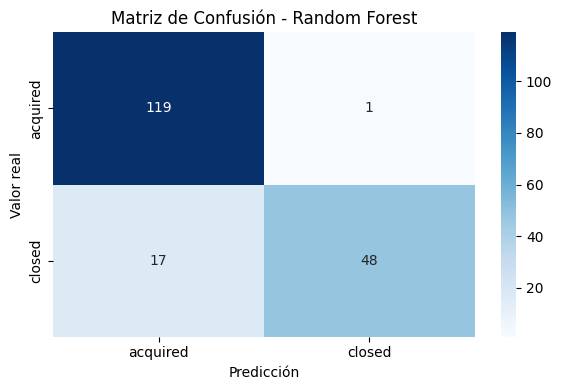


--- Evaluación de XGBoost en test ---
Accuracy en test: 0.8757
Reporte de clasificación:
              precision    recall  f1-score   support

    acquired       0.88      0.94      0.91       120
      closed       0.88      0.75      0.81        65

    accuracy                           0.88       185
   macro avg       0.88      0.85      0.86       185
weighted avg       0.88      0.88      0.87       185



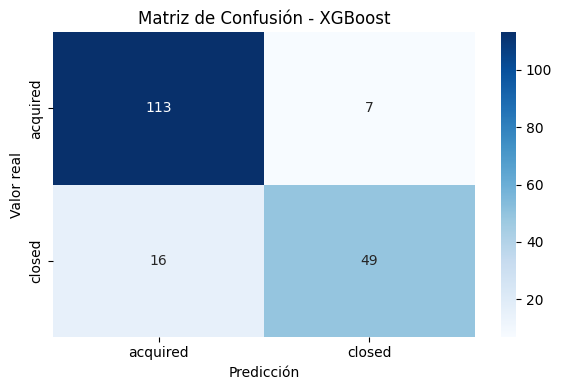

In [7]:
import joblib
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Divide el dataset de nuevo (asegúrate de usar el mismo random_state y test_size)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_encoded
)

# Cargar los mejores modelos guardados
best_rf = joblib.load(MODELS_DIR / "best_rf_model.pkl")
best_xgb = joblib.load(MODELS_DIR / "best_xgb_model.pkl")

# Evaluar en test
for model, name in zip([best_rf, best_xgb], ["Random Forest", "XGBoost"]):
    print(f"\n--- Evaluación de {name} en test ---")
    y_pred = model.predict(X_test)
    print(f"Accuracy en test: {accuracy_score(y_test, y_pred):.4f}")
    print("Reporte de clasificación:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    # Matriz de confusión
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel('Predicción')
    plt.ylabel('Valor real')
    plt.title(f'Matriz de Confusión - {name}')
    plt.tight_layout()
    plt.savefig(f"../reports/figures/model_tuning_and_selection/{name}_confusion_matrix.png")
    plt.show()

## Interpretación de resultados en test

### Random Forest

- **Accuracy en test:** 0.90  
  El modelo acierta el 90% de las predicciones en el conjunto de test, lo que confirma la buena generalización observada en la validación cruzada.

- **Reporte de clasificación:**
  - **Clase "acquired":**
    - *Precision:* 0.88 → De las startups predichas como "acquired", el 88% realmente lo son.
    - *Recall:* 0.99 → De todas las startups realmente "acquired", el modelo identifica correctamente el 99%.
    - *F1-score:* 0.93 → Balance entre precisión y recall, muy alto.
  - **Clase "closed":**
    - *Precision:* 0.98 → De las predichas como "closed", el 98% realmente lo son.
    - *Recall:* 0.74 → El modelo identifica correctamente el 74% de las "closed", pero deja escapar algunas (falsos negativos).
    - *F1-score:* 0.84

- **Matriz de confusión:**  
  El modelo es especialmente fuerte identificando startups exitosas ("acquired"), pero comete algunos errores clasificando "closed" (17 casos de "closed" predichos como "acquired").

---

### XGBoost

- **Accuracy en test:** 0.88  
  Ligeramente inferior al Random Forest, pero aún así robusto.

- **Reporte de clasificación:**
  - **Clase "acquired":**
    - *Precision:* 0.88
    - *Recall:* 0.94
    - *F1-score:* 0.91
  - **Clase "closed":**
    - *Precision:* 0.88
    - *Recall:* 0.75
    - *F1-score:* 0.81

- **Matriz de confusión:**  
  El patrón es similar: el modelo identifica bien "acquired", pero tiene más errores clasificando "closed" (16 falsos negativos).





In [9]:
from sklearn.pipeline import Pipeline
import joblib

# Si tu preprocesamiento ya está hecho y solo necesitas guardar el modelo:
pipeline = Pipeline([
    ('model', best_rf)  # o best_xgb si prefieres ese
])

# Entrena el pipeline (solo necesario si no lo habías hecho ya)
pipeline.fit(X_train, y_train)

# Guarda el pipeline completo
joblib.dump(pipeline, MODELS_DIR / "final_rf_pipeline.pkl")
print("Pipeline completo guardado en:", MODELS_DIR / "final_rf_pipeline.pkl")

Pipeline completo guardado en: C:\Users\alexl\OneDrive\Escritorio\Machine Learning\startups-ml\models\final_rf_pipeline.pkl


In [14]:
import os
import pandas as pd

data_dir = "../data"
os.makedirs(data_dir, exist_ok=True)

X_test.to_csv(f"{data_dir}/X_test.csv", index=False)
y_test_df.to_csv(f"{data_dir}/y_test.csv", index=False)
X_test.head(5).to_csv(f"{data_dir}/nuevos_datos.csv", index=False)

print("¡Archivos X_test.csv, y_test.csv y nuevos_datos.csv exportados correctamente en la carpeta /data!")

¡Archivos X_test.csv, y_test.csv y nuevos_datos.csv exportados correctamente en la carpeta /data!


## Conclusiones

- El modelo Random Forest, tras ajuste de hiperparámetros y validación cruzada, mostró el mejor desempeño en el conjunto de test (accuracy ≈ 90%).
- Ambos modelos presentan alta precisión para identificar startups exitosas ("acquired"), pero menor recall para detectar startups fallidas ("closed").
- La validación cruzada mostró resultados consistentes y robustos, lo que indica buena capacidad de generalización.

